# An illustrative CAT model
A very simplified example of a CAT model and how we would code it in OASIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## A hypothetical island 

Suppose we have an island that is a square shape between coordinates 0<x<10 and 0<y<10.

On the island we have a single circular city, and the value of property is highest in the centre, decreasing as we go out.

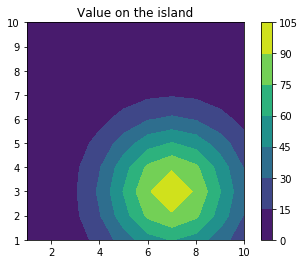

In [2]:
# Define the bounds of our domain and a grid
x0, x1, nx = 1.0, 10.0, 10
y0, y1, ny = 1.0, 10.0, 10

# Assign some value to each grid point and make a city
cityx, cityy = 7.0, 3.0
stddev = 2.0
xi = np.linspace(x0, x1, nx)
yi = np.linspace(y0, y1, ny)
xx, yy = np.meshgrid(xi, yi)

# Value grid
tiv = 100*np.exp( -((xx - cityx)**2 + (yy - cityy)**2) / (2 * stddev**2) )

fig, ax = plt.subplots(1, 1)
h = plt.contourf(xi, yi, tiv)
_ = ax.set(xlim=(x0, x1), ylim=(y0, y1), aspect='equal')
plt.title("Value on the island")
_ = plt.colorbar()

## Hypothetical perils
Suppose our island is affected by a type of storm that travels in a straight line across the island and affects a very narrow region around its path

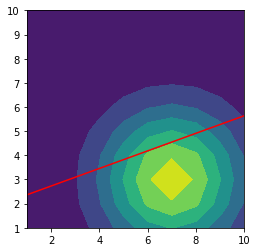

In [3]:
fig, ax = plt.subplots(1, 1)
h = plt.contourf(xi, yi, tiv)
ax.plot(xi, 2.0 + xi*np.tan(np.pi * 20/180), '-r')
_ = ax.set(xlim=(x0, x1), ylim=(y0, y1), aspect='equal')



## Create a hazard module
The hazard module is a simulated set of hypothetical years, each containing a simulated set of events

### Define intensities
First we define how we quantify hazard intensity, e.g. wind speed, flood depth, ground shaking velocity. 

This is some measure that we can eventually relate to damage, and ideally that we can independently verify.

In the OASIS framework, the intensity should be a categorical value. This can be a binning of some scalar value.

In [4]:
intensity_bins = pd.DataFrame({'intensity_bin_index': range(1, 6),
                            'intensity_name': ['low', 'moderate', 'high', 'higher', 'highest'],
                           },
                           index=pd.IntervalIndex.from_breaks([0, 0.1, 0.2, 0.5, 1.0, 2.0], 
                                                              name='intensity_range')
                           )
intensity_bins

,intensity_bin_index,intensity_name
intensity_range,,
"(0.0, 0.1]",1,low
"(0.1, 0.2]",2,moderate
"(0.2, 0.5]",3,high
"(0.5, 1.0]",4,higher
"(1.0, 2.0]",5,highest


### Define some stochastic events
Simulating events is usually a two step process...
1 - You calculate a catalog of the events themselves (e.g. hurricane, earthquake, ...)
2 - You calculate the intensity footprint of each event

In our case, we simplify step 2 by saying that intensity is equal to severity along the track

In [5]:
# Define a set of events that affect our model domain
n_years = 1000  # Number of years to simulate
avg_freq = 1/2  # Poisson rate of event occurrence per year
alpha = 5.0  # Pareto alpha for the event severity
y0_mean = 3.0  # Track geometry
y0_std = 1.0
theta_mean = 30 *np.pi / 180 
theta_kappa = 50

np.random.seed(1234556)

# Calculate number of events
n_events = np.random.poisson(lam=n_years*avg_freq)

# Define event parameters
events = pd.DataFrame({
    'time': np.random.uniform(low=0, high=n_years, size=n_events),
    'severity':  np.random.pareto(a=alpha, size=n_events),
    'y0': np.random.normal(loc=y0_mean, scale=y0_std, size=n_events),
    'theta': np.random.vonmises(mu=theta_mean, kappa=theta_kappa, size=n_events)
}).sort_values('time').reset_index(drop=True)
events.index = pd.Index(range(1, len(events) + 1), name='event_id')
events.head()

,time,severity,y0,theta
event_id,,,,
1,4.550382,0.474897,4.270717,0.502271
2,5.139803,0.209358,3.650509,0.503165
3,9.274795,0.575813,2.379427,0.461216
4,10.594073,0.058227,3.423178,0.607576
5,11.063786,0.473480,2.743074,0.392639


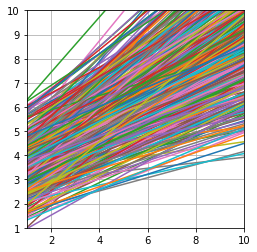

In [6]:
# Plot tracks
xi = np.linspace(x0, x1, nx)
fig, ax = plt.subplots(1, 1)
for idx, row in events.iterrows():
    yi = row.y0 + xi * np.tan(row.theta)
    ax.plot(xi, yi)
plt.grid()
_ = ax.set(xlim=(x0, x1), ylim=(y0, y1), aspect='equal')

# events

### Define intensity calculation zonation
In order to calculate intensity from events on our island, we need to first divide up the island into sub-areas -- an **_areperil_** in OASIS terminology.

This division should capture the granularity of intensity variations from a single event.

We can use the same grid as we did for defining the value distribution over our island. This is a bit of a short cut because we won't have to add a step to map our exposure to areaperils.

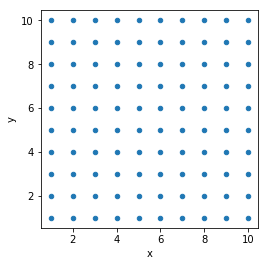

In [7]:
# Define the areaperil table
area_perils = pd.DataFrame({'x': xx.flatten(), 'y': yy.flatten(), 'tiv': tiv.flatten()})
area_perils.index = pd.Index(range(1, len(area_perils) + 1), name='areaperil_id')

# Plot
ax = area_perils.plot.scatter('x', 'y')
_ = ax.set(aspect='equal')

### Calculate the footprint table
The OASIS footprint table has the following columns. It defines the intensity from each event at each areaperil. You can incorporate an intensity distribution to incorporate uncertainty, but we don't (prob=1.0).

| Name               | Type   |  Bytes | Description                                                   | Example     |
|:-------------------|--------|--------| :-------------------------------------------------------------|------------:|
| event_id           | int    |    4   | Oasis event_id                                                |     1       |
| areaperil_id       | int    |    4   | Oasis areaperil_id                                            |   4545      |
| intensity_bin_index| int    |    4   | Identifier of the intensity damage bin                        |     10      |
| prob               | float  |    4   | The probability mass for the intensity bin between 0 and 1    |    0.765    | 

In [8]:
# calculate the footprints
xi = np.linspace(x0, x1, nx*10) 
footprints = pd.DataFrame([], columns=['event_id', 'areaperil_id', 'intensity_id', 'prob'])
for idx, row in events.iterrows():

    yi = row.y0 + xi * np.tan(row.theta)
    intensity = min(row.severity, intensity_bins.index.right.max())
    
    fp = (pd.DataFrame({'x': np.round((xi - x0)*(x1 - x0) / (nx - 1)), 
                        'y': np.round((yi - y0)*(y1 - y0) / (ny - 1))})
          .drop_duplicates()
          .assign(intensity_id=intensity_bins['intensity_bin_index'][intensity])
          .assign(event_id=idx)
          .merge(area_perils[['x', 'y']].reset_index(), how='inner', on=['x', 'y'])
          .assign(prob=1.0)
         )
 
    footprints = footprints.append(
        fp[['event_id', 'areaperil_id', 'intensity_id', 'prob']])

footprints.set_index(['event_id', 'areaperil_id', 'intensity_id']).head()

prob
event_id areaperil_id intensity_id      
1        31           3              1.0
         41           3              1.0
         42           3              1.0
         43           3              1.0
         53           3              1.0

In [9]:
footprints.head()

,event_id,areaperil_id,intensity_id,prob
0,1,31,3,1.0
1,1,41,3,1.0
2,1,42,3,1.0
3,1,43,3,1.0
4,1,53,3,1.0


## Create a vulnerabilty module
The vulnerability module is a database of mapping tables that convert hazard intensity into damage, depending on the characteristics of the risk affected.

### Define vulnerability
_Vulnerability_ defines how hazard relates to damage.

_Damage_ is typically characterized as a ratio to the total value of the insured item.

We'd usually define different vulnerability for different risk types (e.g. house vs boat vs factory). Here, just one.

Also the uncertainty of expected damage is simplified to one of two values here. It usually would be more sophisticated.

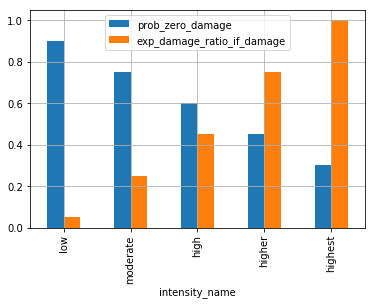

In [10]:
# For each intensty, the probability that there's zero damage
intensity_bins['prob_zero_damage'] = [0.9, 0.75, 0.6, 0.45, 0.3]

# For each intensity, the expected damage ratio on condition that damage occurs
intensity_bins['exp_damage_ratio_if_damage'] = [0.05, 0.25, 0.45, 0.75, 1.0]

_ = intensity_bins.drop('intensity_bin_index', axis=1).plot.bar('intensity_name', grid=True)
#intensity_bins

### Damage bin table
For OASIS, we have to quantify damage into specific pre-defined bins.
```
bin_index, bin_from, bin_to, interpolation, interval_type
```

In [11]:
# Define damage bins
bin_edges = np.append(0.0, np.append(np.linspace(0.0, 1.0, 11), 1.0))
damage_bins = pd.DataFrame({
    'bin_from': bin_edges[:-1],
    'bin_to': bin_edges[1:],
}, index = pd.Index(range(1, len(bin_edges)), name='bin_index'))
damage_bins['interpolation'] = 0.5*(damage_bins['bin_from'] + damage_bins['bin_to'])
damage_bins['interval_type'] = 1201
damage_bins

,bin_from,bin_to,interpolation,interval_type
bin_index,,,,
1,0.0,0.0,0.00,1201
2,0.0,0.1,0.05,1201
3,0.1,0.2,0.15,1201
4,0.2,0.3,0.25,1201
5,0.3,0.4,0.35,1201
6,0.4,0.5,0.45,1201
7,0.5,0.6,0.55,1201
8,0.6,0.7,0.65,1201
9,0.7,0.8,0.75,1201


### Vulnerabilty table

| Name                 | Type   |  Bytes | Description                                   | Example   |
|:---------------------|--------|--------| :---------------------------------------------|----------:|
| vulnerability_id     | int    |    4   | Oasis vulnerability_id                        |     45    |
| intensity_bin_index  | int    |    4   | Identifier of the hazard intensity bin        |     10    |
| damage_bin_index     | int    |    4   | Identifier of the damage bin                  |     20    |
| prob                 | float  |    4   | The probability mass for the damage bin       |    0.186  | 


In [12]:
vuln_id = 1

# Get the damage bin for each expected damage ratio
bin_edges[-1] = np.inf
damage_bin_ids = (pd.Series(damage_bins.index, 
                            index=pd.IntervalIndex.from_breaks(bin_edges, closed='left'))
                 [intensity_bins['exp_damage_ratio_if_damage']].values
                 )

# Get the zero damage probabilities
vulnerability = (intensity_bins[['intensity_bin_index', 'prob_zero_damage']]
                 .reset_index(drop=True)
                 .assign(vulnerability_id=vuln_id)
                 .assign(damage_bin_index=damage_bins.index.values[0])
                 .rename(columns={'prob_zero_damage': 'prob'})
                )

# Get the non-zero damage probabilities
vulnerability = vulnerability.append(vulnerability
                                      .assign(damage_bin_index=damage_bin_ids)
                                      .assign(prob=lambda df: 1 - df['prob'])
                                     )[['vulnerability_id', 
                                        'intensity_bin_index', 
                                        'damage_bin_index', 
                                        'prob']].sort_values(['vulnerability_id', 
                                        'intensity_bin_index', 
                                        'damage_bin_index', 
                                        'prob'])
assert all(vulnerability.groupby(
    ['vulnerability_id', 'intensity_bin_index'])['prob'].sum() == 1.0)

In [13]:
vulnerability

,vulnerability_id,intensity_bin_index,damage_bin_index,prob
0,1,1,1,0.90
0,1,1,2,0.10
1,1,2,1,0.75
1,1,2,4,0.25
2,1,3,1,0.60
2,1,3,6,0.40
3,1,4,1,0.45
3,1,4,9,0.55
4,1,5,1,0.30
4,1,5,12,0.70


## Set up OASIS "static" data tables
These are the model files that don't change from one run to another

In [14]:
# Write static data tables to file
import os
import shutil

# Make a fresh folder. These files must have the right name and directory.
if os.path.exists('static'):
    shutil.rmtree('static')
os.makedirs("static")

# Write the csv files
damage_bins.to_csv('static/damage_bin_dict.csv', index=True)
vulnerability.to_csv('static/vulnerability.csv', index=False)
footprints.to_csv('static/footprint.csv', index=False)

# These parameters needed for binary conversion
n_damage_bins = len(damage_bins)
n_intensity_bins = len(intensity_bins)

!ls -l static

total 92
-rw-rw----. 1 u006448 NATCAT_RND   445 Apr  2 16:24 damage_bin_dict.csv
-rw-rw----. 1 u006448 NATCAT_RND 83100 Apr  2 16:24 footprint.csv
-rw-rw----. 1 u006448 NATCAT_RND   180 Apr  2 16:24 vulnerability.csv


### Convert from csv to OASIS binary format, using OASIS tools

In [15]:
%%bash -s "$n_damage_bins" "$n_intensity_bins"
PATH=$(pwd)/venv/bin/:$PATH

# Convert the damage bin file
damagebintobin < static/damage_bin_dict.csv > static/damage_bin_dict.bin

# Convert the vulnerability file
vulnerabilitytobin -d $1 < static/vulnerability.csv > static/vulnerability.bin

# Convert the footprint table, assuming no intensity uncertainty
cd static
footprinttobin -i $2 -n < footprint.csv
cd ..

ls -l static

total 192
-rw-rw----. 1 u006448 NATCAT_RND   240 Apr  2 16:24 damage_bin_dict.bin
-rw-rw----. 1 u006448 NATCAT_RND   445 Apr  2 16:24 damage_bin_dict.csv
-rw-rw----. 1 u006448 NATCAT_RND 78056 Apr  2 16:24 footprint.bin
-rw-rw----. 1 u006448 NATCAT_RND 83100 Apr  2 16:24 footprint.csv
-rw-rw----. 1 u006448 NATCAT_RND  9820 Apr  2 16:24 footprint.idx
-rw-rw----. 1 u006448 NATCAT_RND   164 Apr  2 16:24 vulnerability.bin
-rw-rw----. 1 u006448 NATCAT_RND   180 Apr  2 16:24 vulnerability.csv


## Create the OASIS input files
These are files that change depending on ...

1 - the input exposure for which you want to calculate loss
2 - the analysis settings

### Exposure input files
We will skip the financial engine and run ground up loss. In that case, we need two files:
1. coverages: detailing the value of each coverage
2. items: mapping the coverages to areaperils and vulnerabilities, also defining correlation of uncertainty sampling

| Name              | Type   | Bytes | Description                                    | Example   |
|:------------------|--------|-------|:-----------------------------------------------|----------:|
| item_id           | int    |   4   | Identifier of the exposure item                |    1      |
| coverage_id       | int    |   4   | Identifier of the coverage                     |    3      |
| areaperil_id      | int    |   4   | Identifier of the locator and peril            |   4545    |
| vulnerability_id  | int    |   4   | Identifier of the vulnerability distribution   |   645     |
| group_id			| int    |   4   | Identifier of the correlaton group             |    3      |

In [16]:
coverages = area_perils[['tiv']].copy()
coverages.index.name = 'coverage_id'
coverages.head()

,tiv
coverage_id,
1,0.673795
2,2.664910
3,8.208500
4,19.691168
5,36.787944


In [17]:
items = (area_perils.reset_index()[['areaperil_id']].copy()
         .assign(vulnerability_id=vuln_id)
         .assign(coverage_id=area_perils.index)
         .assign(item_id=area_perils.index)
         .assign(group_id=area_perils.index)
         .set_index('item_id')
         [['coverage_id', 'areaperil_id', 'vulnerability_id', 'group_id']]
        )
items.head()

,coverage_id,areaperil_id,vulnerability_id,group_id
item_id,,,,
1,1,1,1,1
2,2,2,1,2
3,3,3,1,3
4,4,4,1,4
5,5,5,1,5


### Summary xref
The summary xref defines how granular we want our loss results. 

We want to sum the losses over all grid points and output a loss per event and per loss sample

| Name                  | Type   |  Bytes | Description                                   | Example  |
|:----------------------|--------|--------|:----------------------------------------------|---------:|
| item_id / coverage_id | int    |    4   | Identifier of the item or coverage            |   3      |
| summary_id            | int    |    4   | Identifier of the summary level grouping      |   3      |
| summaryset_id         | int    |    4   | Identifier of the summary set                 |   1      |

In [18]:
gulsummaryxref = pd.DataFrame({
    'item_id': area_perils.index,
    'summary_id': 1,
    'summaryset_id': 1
})
gulsummaryxref.head()

,item_id,summary_id,summaryset_id
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


## Write our input files 
Same as for the static folders, but in a different folder

In [19]:
# Write to file
if os.path.exists('input'):
    shutil.rmtree('input')
os.makedirs("input")

# Which events we want to run (all of them)
events.reset_index()['event_id'].to_csv('input/events.csv', index=False, header=True)

# Exposure inputs
coverages.to_csv("input/coverages.csv", index=True)
items.to_csv("input/items.csv", index=True)

# Output mapping
gulsummaryxref.to_csv("input/gulsummaryxref.csv", index=False)

### Convert to binary format

In [20]:
%%bash 
PATH=./venv/bin/:$PATH
evetobin < input/events.csv > input/events.bin
coveragetobin < input/coverages.csv > input/coverages.bin
itemtobin < input/items.csv > input/items.bin
gulsummaryxreftobin < input/gulsummaryxref.csv > input/gulsummaryxref.bin

## Run the OASIS ktools calculation
Now all our input/static files are in place, we can run the workflow, piping output of one module to another

1. eve divides up the events into calculation streams
2. getmodel finds the areaperils and vulnerability curves needed, then calculates damage distribution functions for each event and each location
3. gulcalc samples the distribution functions to calculate losses
4. summarycalc applies the mapping to produce the output losses at requested granularity

In [21]:
# How many uncertainty samples do we want
n_samples = 100

In [22]:
%%bash -s "$n_samples"
PATH=./venv/bin/:$PATH
eve 1 1 | getmodel | \
    gulcalc -S$1 -s1234 -a0 -c - | \
    summarycalc -g -1 - | \
    summarycalctocsv > summarycalc.csv

## Check the output
summarycalc file has a loss for each summary_id in the xref file, and each event and each uncertainty sample

sidx = -1 is the analytical mean loss

In [23]:
# Read the file
sumcalc = pd.read_csv("summarycalc.csv").set_index(['summary_id', 'event_id', 'sidx'])
sumcalc = sumcalc.loc[1].drop(-1, axis=0, level='sidx')
sumcalc.head()

loss
event_id sidx      
368      1     0.33
         2     0.27
         3     0.73
         4     0.78
         5     2.01

In [24]:
# Calculate the average annual loss
aal = sumcalc['loss'].sum() / n_years / n_samples
print(f"AAL = {aal:,.2f}")

AAL = 14.38


In [25]:
# Combine the summarycalc with the event information to get a year loss table
ylt = sumcalc.join(events['time']).reset_index()
ylt['year'] = np.floor(ylt['time'])
ylt = ylt.groupby(['year', 'sidx'])['loss'].agg(['sum', 'max'])

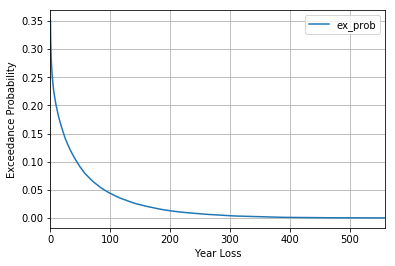

In [26]:
ep_curve = ylt.sort_values('sum', ascending=False)
ep_curve['ex_prob'] = np.arange(1, len(ep_curve) + 1) / n_years / n_samples
ep_curve['return_period'] = 1 / ep_curve['ex_prob']
ax = ep_curve.plot('sum', 'ex_prob', grid=True)
_ = ax.set(xlabel='Year Loss', ylabel='Exceedance Probability')